# Business case 


Addressing Customer Churn: A Strategic Priority for Telecom Companies

Customer churn, where customers discontinue their service, is a key concern in the telecom industry, where annual churn rates can reach 25%. Churn has a significant financial impact, as retaining existing customers is much more cost-effective than acquiring new ones. Research shows that acquisition costs are typically 5 to 25 times higher than retention costs, making churn reduction essential to sustaining revenue and boosting profitability.

Financial Imperatives for Churn Reduction

Predictive churn models can help telecom companies proactively identify high-risk customers, allowing for targeted retention efforts. By retaining more customers, companies increase customer lifetime value (CLV) and reduce operational costs, leading to higher profit margins.

A Holistic Approach to Churn Detection

To effectively address churn, companies need a comprehensive view of customer behavior across multiple channels, including store visits, purchase histories, customer service interactions, online activity, and social media engagement. Identifying behavioral patterns and high-risk segments allows companies to prioritize retention efforts where they will have the greatest impact.

Objectives of This Analysis

This analysis explores key questions to drive effective retention strategies:
	-Churn Rate Analysis: What percentage of customers are churning, and what revenue is at risk?

-Customer Segmentation: Are there patterns in churn based on demographics or service preferences?

-Service Profitability: Which service types contribute most to revenue, and where should retention focus?

-Feature Profitability: Which features drive profitability and should be prioritized in retention strategies?

By understanding churn dynamics, telecom companies can retain high-value customers, reduce acquisition costs, and strengthen their market position for sustainable growth.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Read data 

In [3]:
#read Data 
df=pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Missing Values

In [5]:
#investigate missing values 
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
#investigate hidden missing values in numerical attributes 
numerical_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
for col in numerical_cols:
  df[col] = pd.to_numeric(df[col], errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [8]:
# Drop rows where 'TotalCharges'  has null values
df_cleaned = df.dropna(subset=['TotalCharges'])

In [9]:
#drop unecessary columns 
df_cleaned.drop(['customerID'],axis=1,inplace=True)

In [10]:
df_cleaned.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

# Data Visualization 

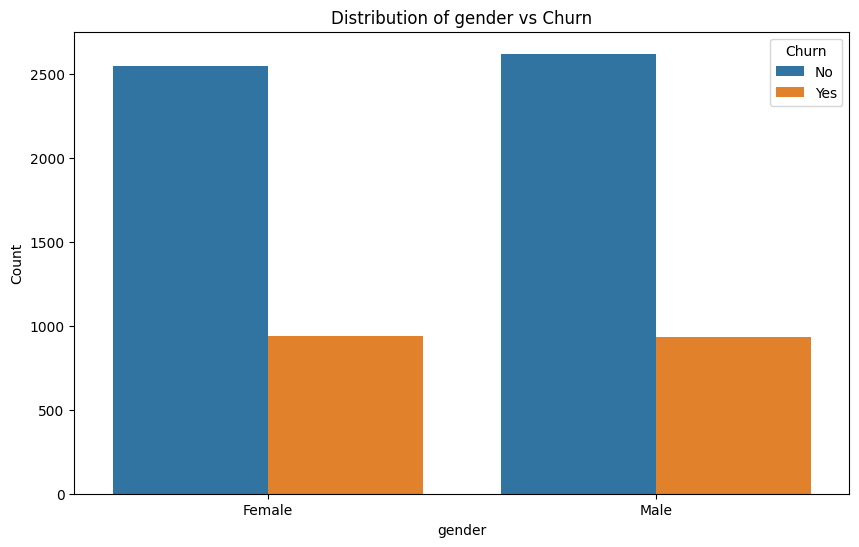

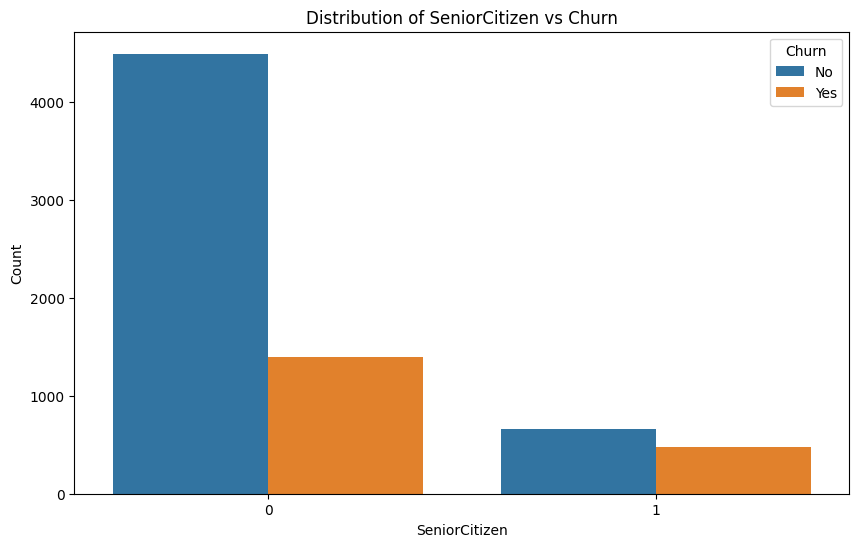

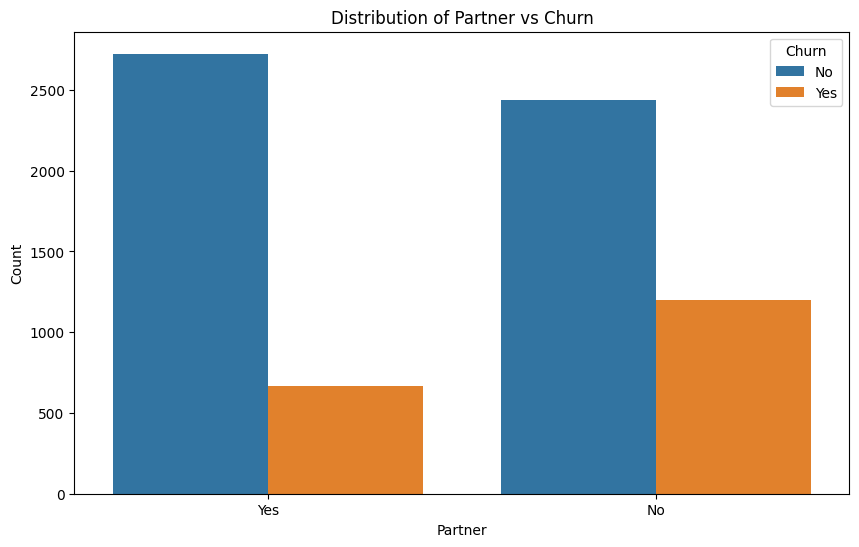

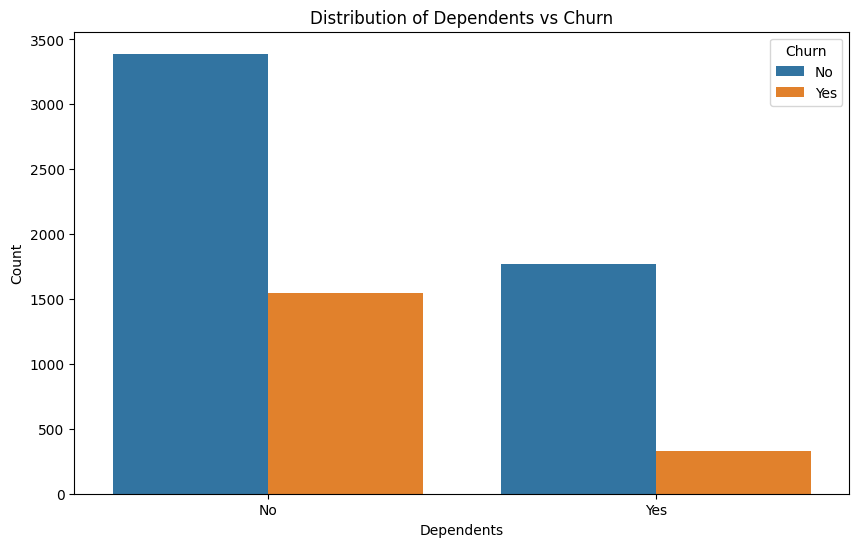

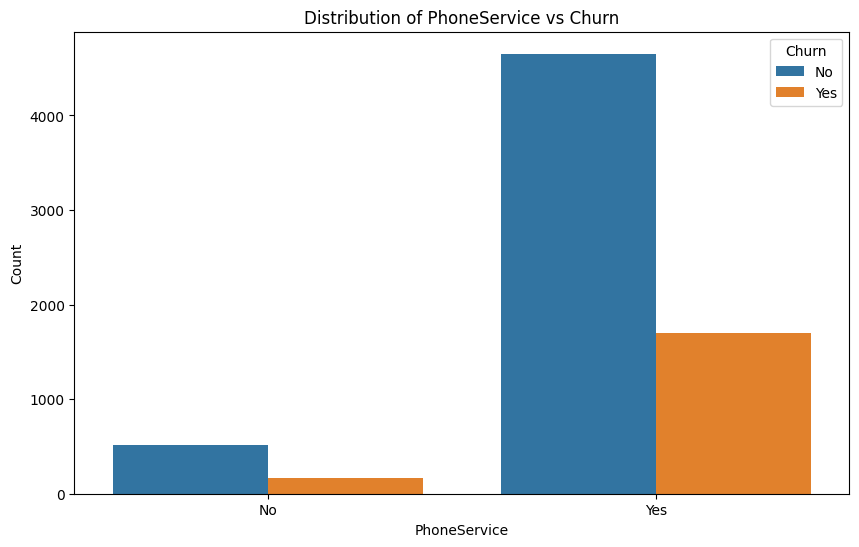

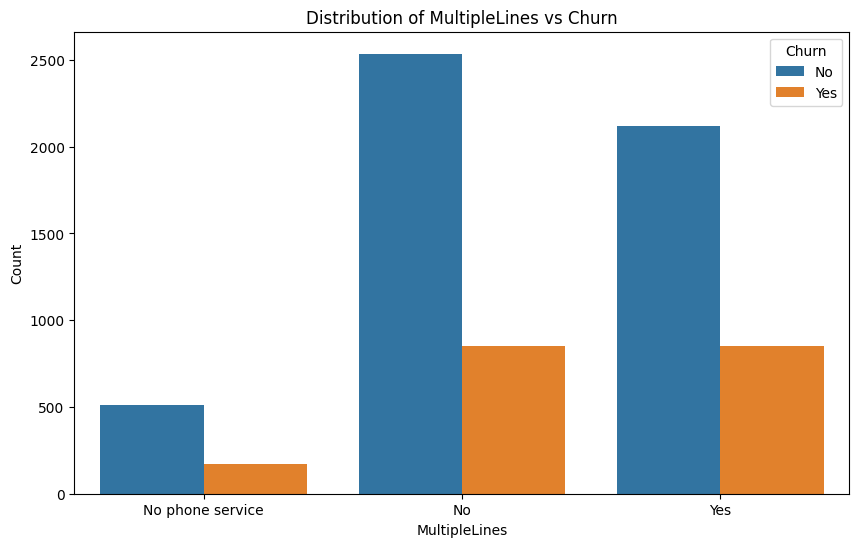

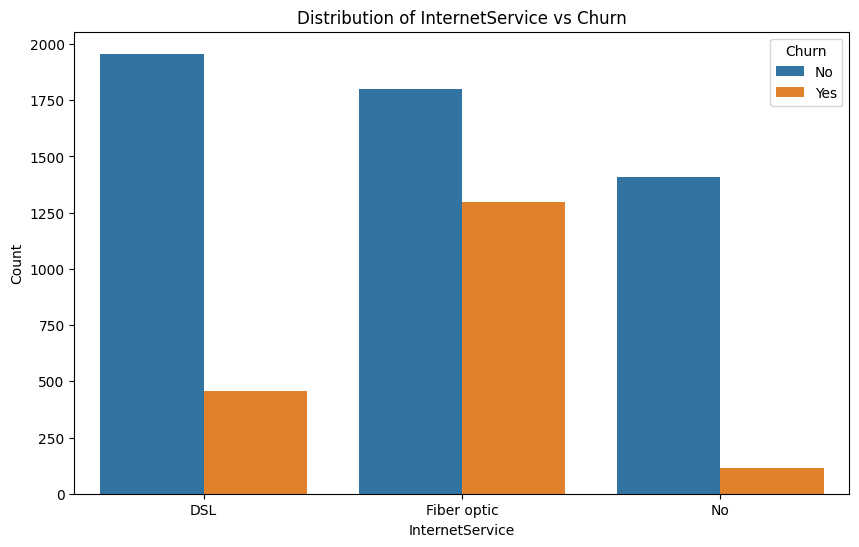

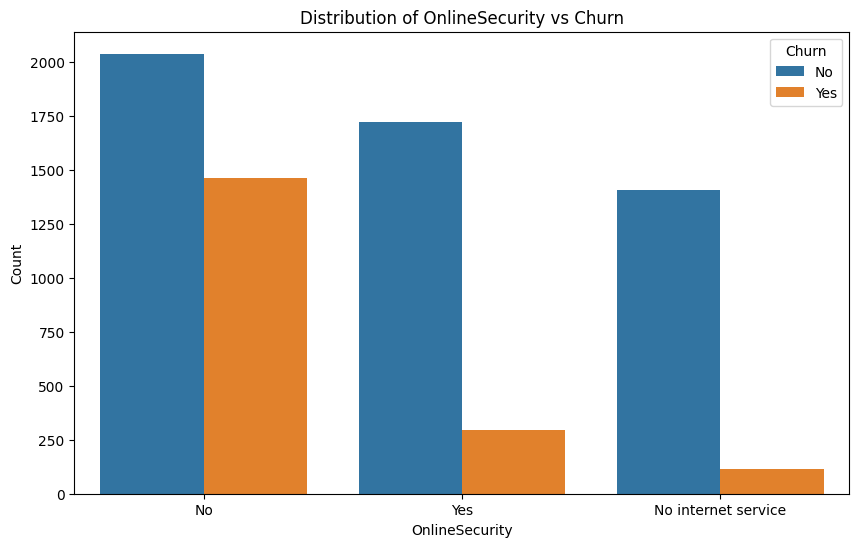

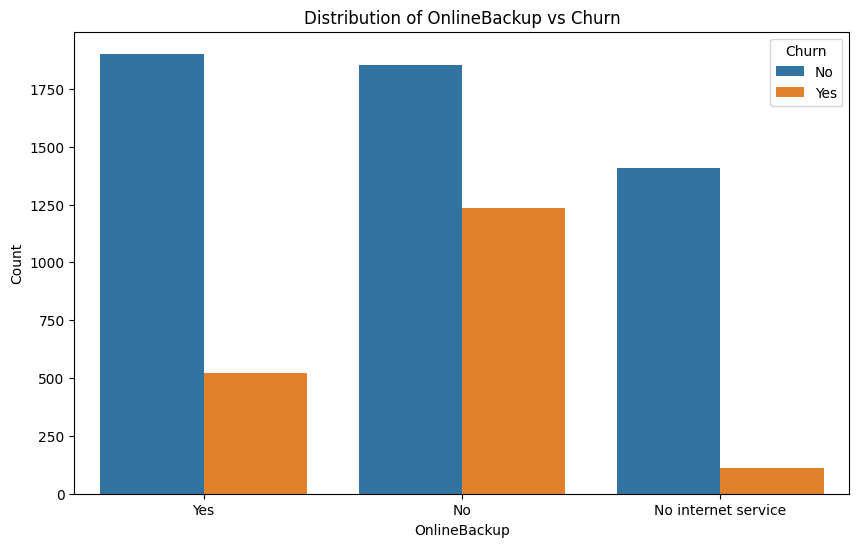

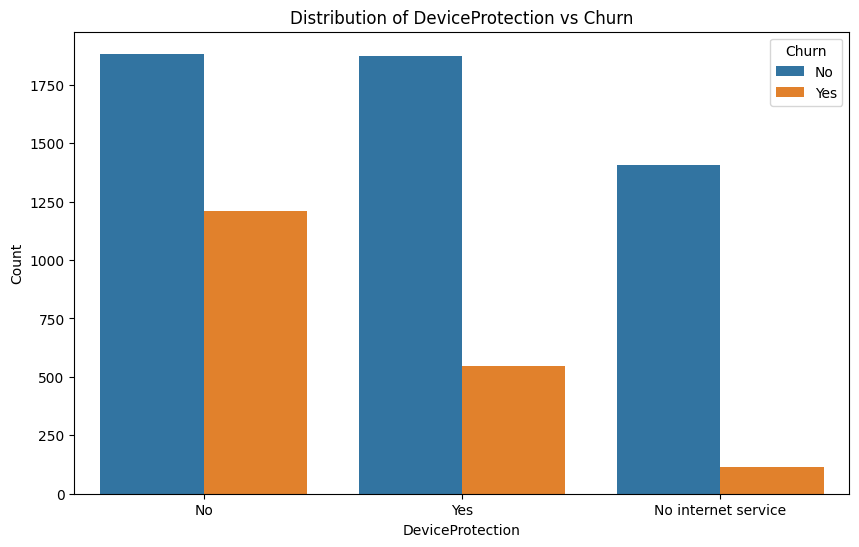

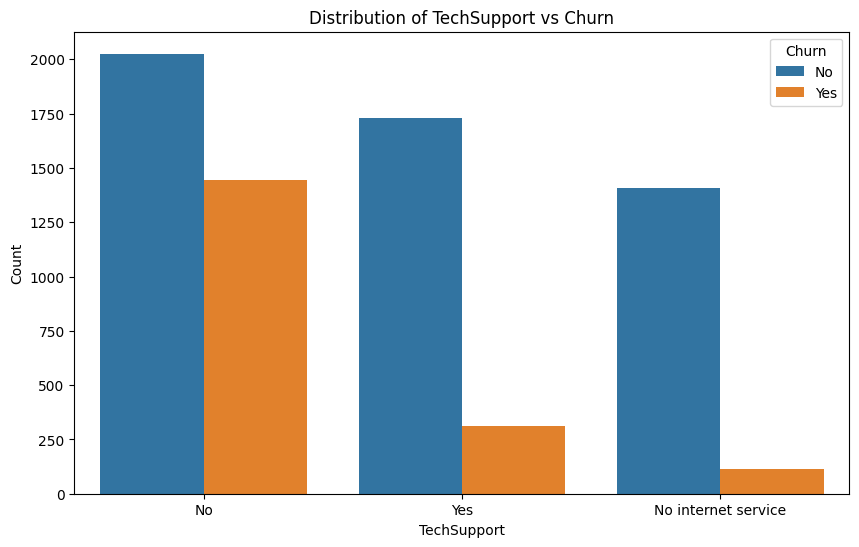

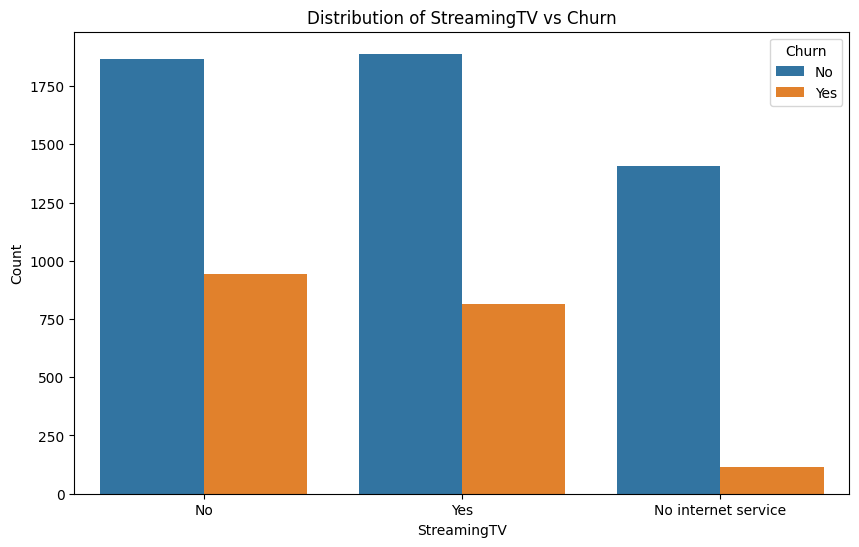

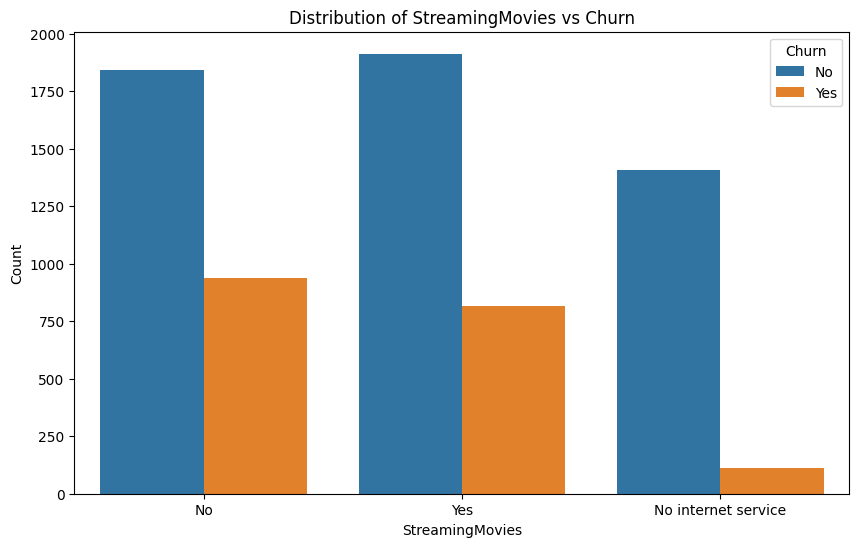

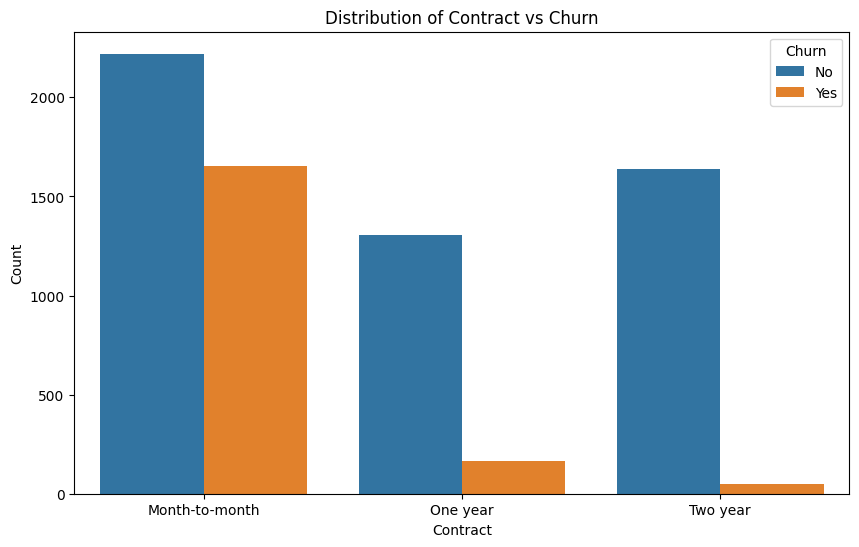

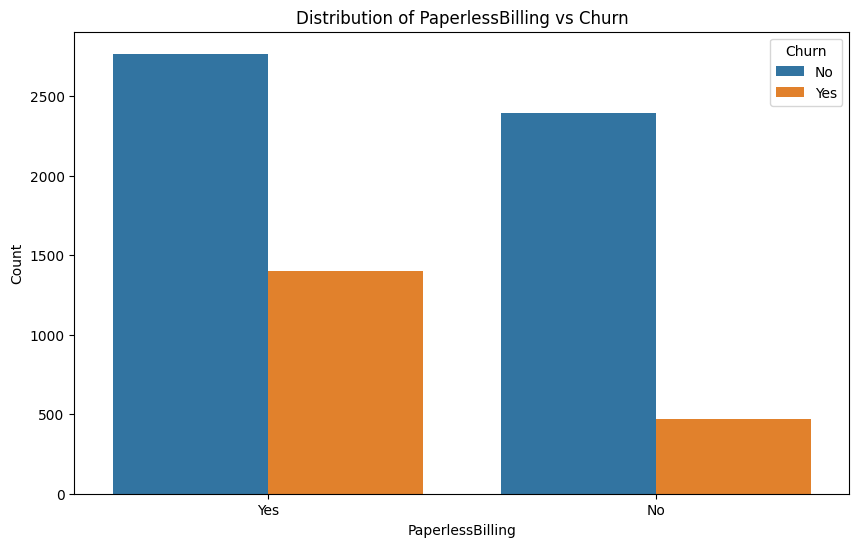

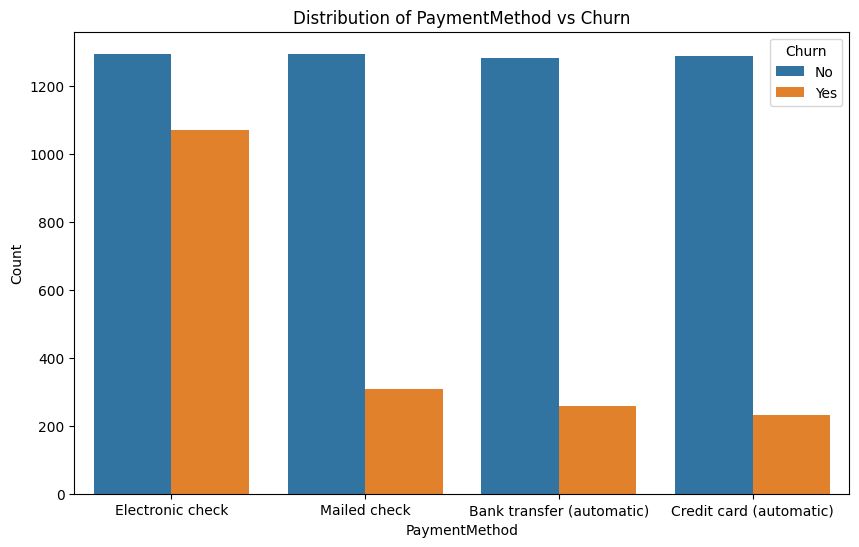

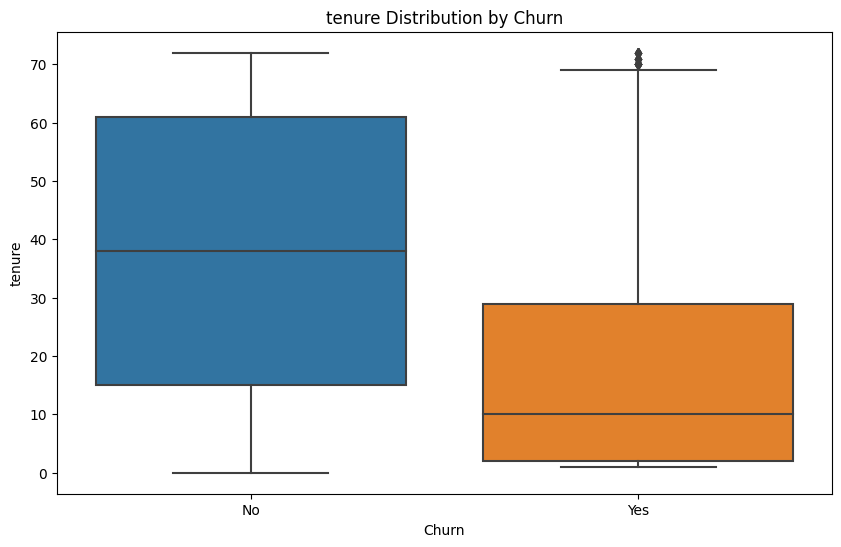

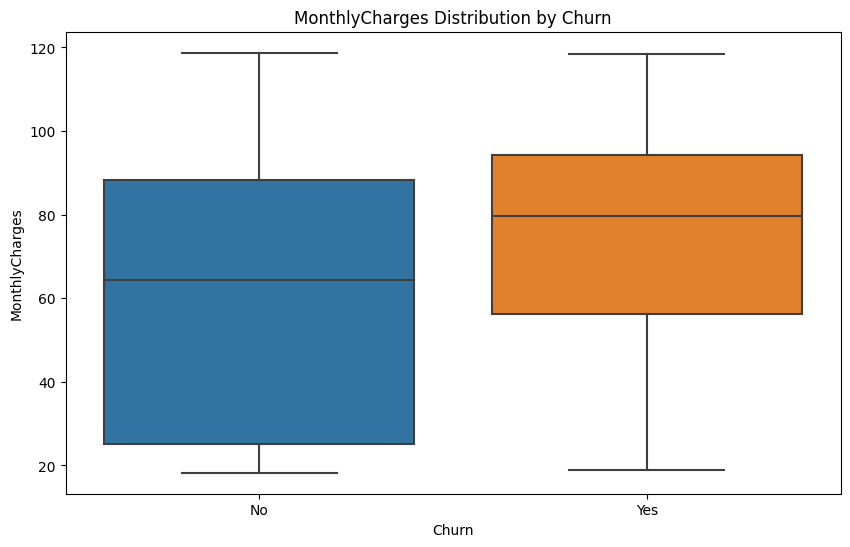

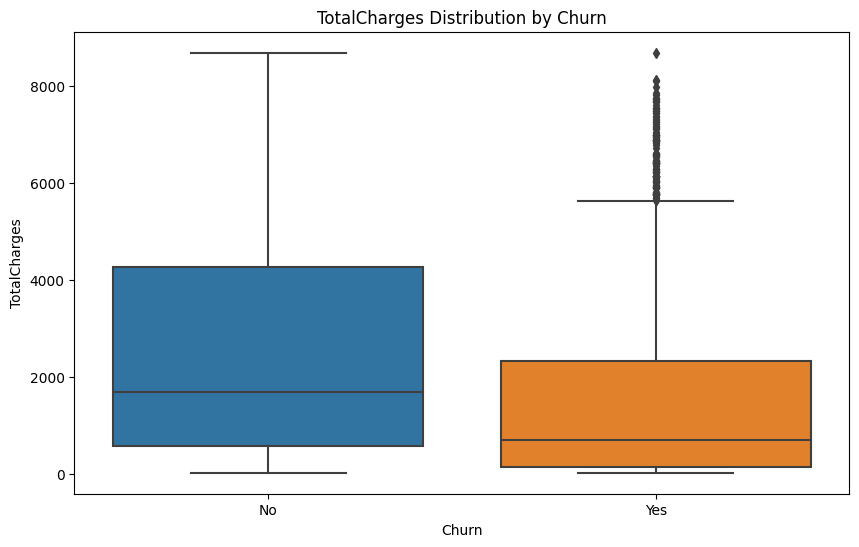

In [12]:
# List of categorical and numerical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot each categorical variable with respect to Churn
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_cleaned, x=col, hue='Churn')
    plt.title(f'Distribution of {col} vs Churn')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Churn', loc='upper right')
    plt.show()

# Plot each numerical variable with respect to Churn
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f'{col} Distribution by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.show()

# Handling Categorical attributes 

In [13]:
#Handling Categorical Features 
#Display unique values for each categorical column
for col in df_cleaned.select_dtypes(include=['object', 'category']).columns:
    unique_values = df_cleaned[col].unique()
    print(f"{col}: {unique_values}\n")

gender: ['Female' 'Male']

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']

PhoneService: ['No' 'Yes']

MultipleLines: ['No phone service' 'No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No internet service']

OnlineBackup: ['Yes' 'No' 'No internet service']

DeviceProtection: ['No' 'Yes' 'No internet service']

TechSupport: ['No' 'Yes' 'No internet service']

StreamingTV: ['No' 'Yes' 'No internet service']

StreamingMovies: ['No' 'Yes' 'No internet service']

Contract: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: ['Yes' 'No']

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Churn: ['No' 'Yes']



In [14]:
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaperlessBilling', 'PaymentMethod','Churn']
from sklearn.preprocessing import LabelEncoder
#Initialize the LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
   df_cleaned[col] = le.fit_transform(df_cleaned[col])
   # Display the first few rows of the modified DataFrame
df_cleaned.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


# Handling Numerical Attributes 

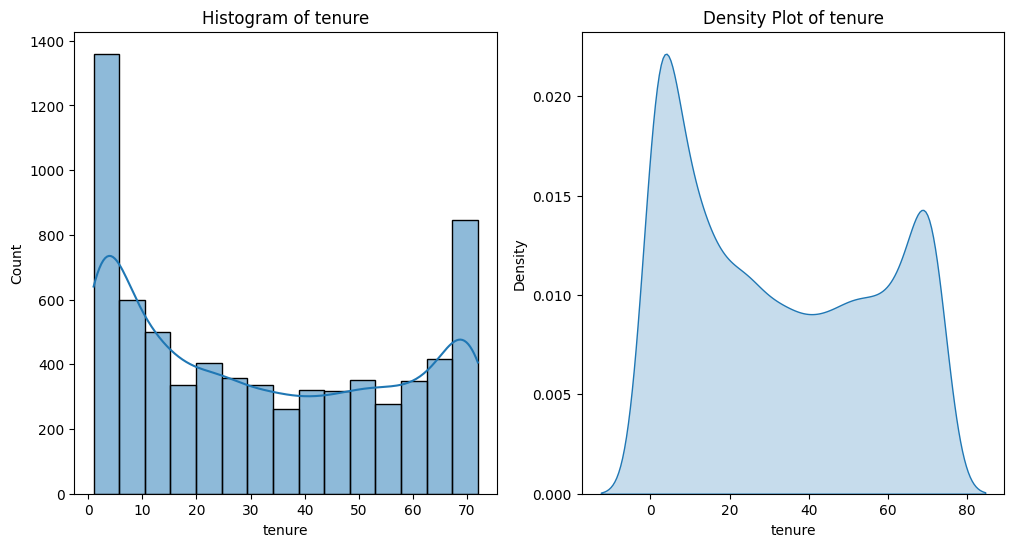

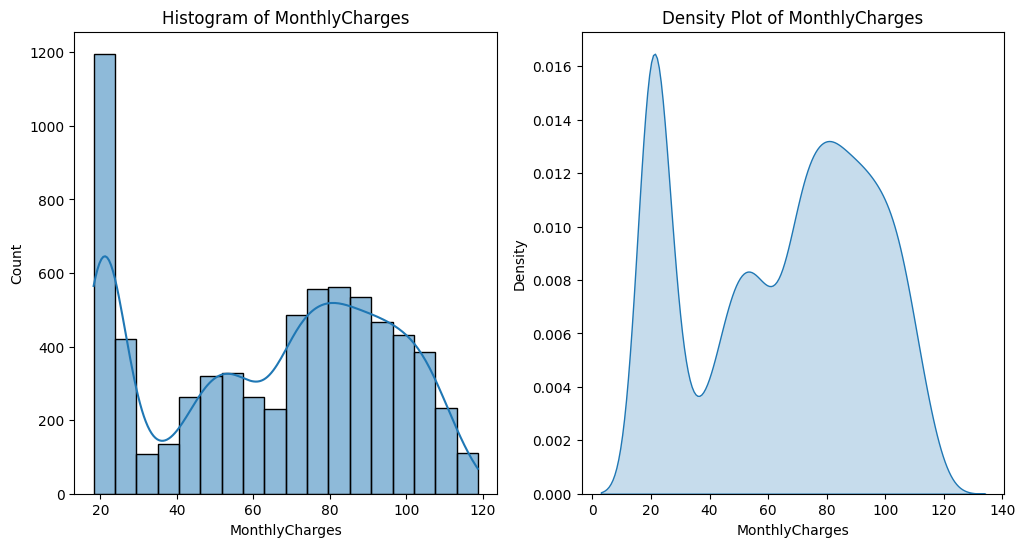

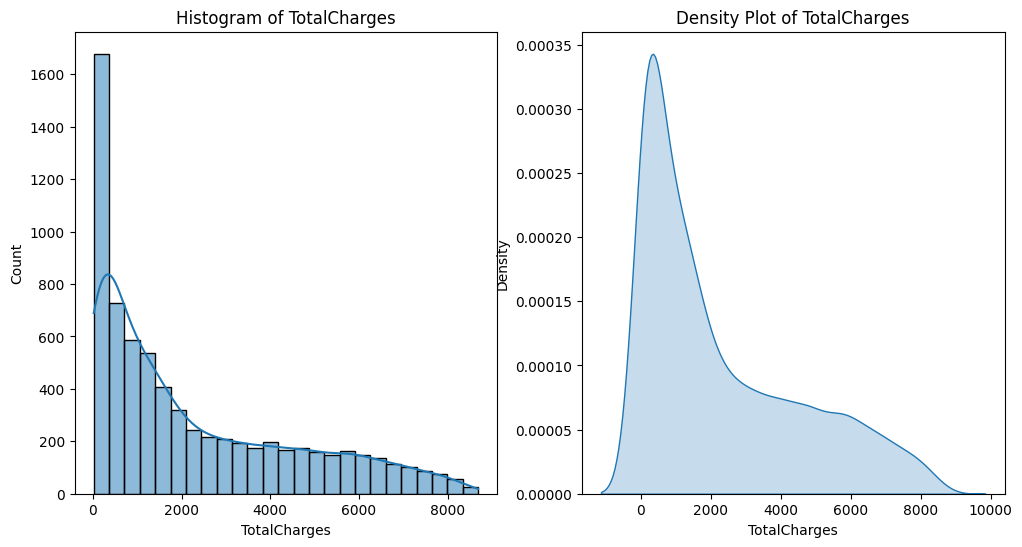

In [15]:
#List of numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
#Plot histograms and density plots
for col in numerical_cols:
    plt.figure(figsize=(12, 6))
    #histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')
    #density plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(df[col], shade=True)
    plt.title(f'Density Plot of {col}')
    plt.show()

# Split Train/Test

In [16]:
from sklearn.model_selection import train_test_split
X = df_cleaned.drop(columns=['Churn'])
y = df_cleaned['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (5625, 19) (5625,)
Test set shape: (1407, 19) (1407,)


# Buid ML models 
- Logistic Regression
- Decision Tree
- RF
- Gradient Boosting
- XGboost
- KNN
- SVM

In [17]:
def Build_models(X_train, y_train, X_test, y_test, scoring='roc_auc', search='random'):
    #Define models and their hyperparameter grids for tuning
    models = {
        'Logistic Regression': {
            'model': Pipeline([
                ('scaler', StandardScaler()),  
                ('classifier', LogisticRegression(max_iter=1000, random_state=42))
            ]),
            'params': {
                'classifier__C': [0.1, 1, 10, 100],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear', 'saga']
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        },
        'K-Nearest Neighbors': {
            'model': Pipeline([
                ('scaler', StandardScaler()),  
                ('classifier', KNeighborsClassifier())
            ]),
            'params': {
                'classifier__n_neighbors': [3, 5, 7, 9],
                'classifier__weights': ['uniform', 'distance'],
                'classifier__p': [1, 2]
            }
        },
        'SVM': {
            'model': Pipeline([
                ('scaler', StandardScaler()), 
                ('classifier', SVC(probability=True, random_state=42))
            ]),
            'params': {
                'classifier__C': [0.1, 1, 10, 100],
                'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'classifier__gamma': ['scale', 'auto']
            }
        }
    }
    
    #Dictionary to store the best test score for each model
    model_scores = {}

    #Iterate over each model and perform hyperparameter tuning and evaluation on the test set
    for model_name, model_info in models.items():
        print(f"Training {model_name} with hyperparameter tuning...")
        
        if search == 'grid':
            search_model = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring=scoring, n_jobs=-1, verbose=1)
        else:
            search_model = RandomizedSearchCV(model_info['model'], model_info['params'], cv=5, scoring=scoring, n_jobs=-1, verbose=1, n_iter=20, random_state=42)
        #Fit the search model on the training data
        search_model.fit(X_train, y_train)
        #Get the best estimator and evaluate it on the test set
        best_model = search_model.best_estimator_
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]  
        test_score = roc_auc_score(y_test, y_pred_proba) 
        #Store the test score, best parameters, and best model
        model_scores[model_name] = {'Test Score': test_score, 'Best Params': search_model.best_params_, 'Best Model': best_model}
        print(f"{model_name}: Test {scoring} = {test_score:.4f}")
        print(f"Best Parameters: {search_model.best_params_}\n")

    #Find the model with the highest test score
    best_model_name = max(model_scores, key=lambda x: model_scores[x]['Test Score'])
    best_model_info = model_scores[best_model_name]
    
    print(f"\nBest Overall Model on Test Set: {best_model_name} with {scoring} = {best_model_info['Test Score']:.4f}")
    print(f"Best Parameters for {best_model_name}: {best_model_info['Best Params']}\n")
    
    return best_model_info['Best Model'], model_scores

best_model, model_scores = Build_models(X_train, y_train, X_test, y_test, scoring='roc_auc', search='random')

Training Logistic Regression with hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Logistic Regression: Test roc_auc = 0.8308
Best Parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 100}

Training Decision Tree with hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Decision Tree: Test roc_auc = 0.7609
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}

Training Random Forest with hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Forest: Test roc_auc = 0.8284
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}

Training Gradient Boosting with hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Gradient Boosting: Test roc_auc = 0.8326
Best Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

Training XGBoost with hyperpar

# Evaluate Best Model

AUC Score: 0.8337

Confusion Matrix:
 [[958  75]
 [220 154]]


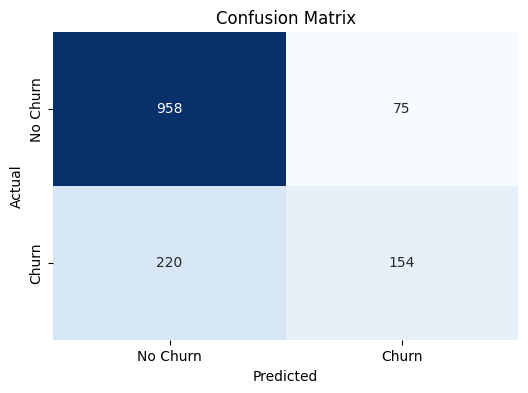


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      1033
           1       0.67      0.41      0.51       374

    accuracy                           0.79      1407
   macro avg       0.74      0.67      0.69      1407
weighted avg       0.78      0.79      0.77      1407



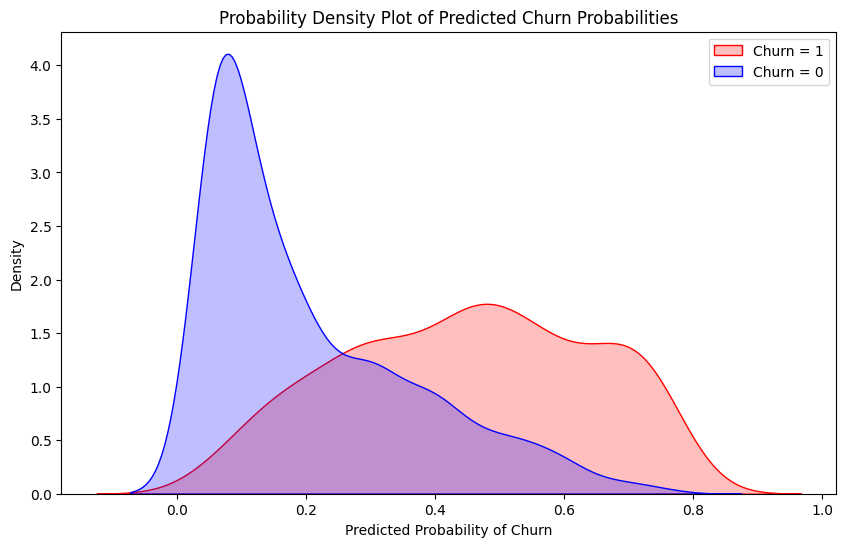

In [18]:
def evaluate_best_model(best_model, X_test, y_test):
    #Make probability prediction on the test set
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  
    y_pred = best_model.predict(X_test)
    
    #AUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score: {auc_score:.4f}")
    
    #Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", conf_matrix)
    
    #Plot cm
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    #Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    #Probability Density Plot for Churn Probabilities
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_pred_proba[y_test == 1], label="Churn = 1", color="red", shade=True)
    sns.kdeplot(y_pred_proba[y_test == 0], label="Churn = 0", color="blue", shade=True)
    plt.xlabel("Predicted Probability of Churn")
    plt.ylabel("Density")
    plt.title("Probability Density Plot of Predicted Churn Probabilities")
    plt.legend()
    plt.show()
evaluate_best_model(best_model, X_test, y_test)